In [1]:
import os
import findspark

os.environ["SPARK_HOME"] = "C:\spark"
findspark.init()

# To display scroll:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
    .appName('Challenge 3')\
    .getOrCreate()
spark

In [3]:
df = spark.read.parquet('dataset_ml_parquet')

In [4]:
df.show(5)

+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio| iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00002dd9-cc74-480...|    2|       35|        1|      1|   0.0| 0.0|Santo Cristo|     100.0|100.0|245000.0|           1|         0|     

# Transforming data

In [5]:
from pyspark.ml.feature import StringIndexer

In [45]:
# TODO: Try exploding into different columns
indexed = StringIndexer(inputCol='bairro', outputCol='bairro_ind').fit(df).transform(df)

In [46]:
indexed.show(5)

+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+----------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio| iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|bairro_ind|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+----------+
|00002dd9-cc74-480...|    2|       35|        1|      1|   0.0| 0.0|Santo Cristo|     100.0|100.0|24500

In [47]:
from pyspark.ml.feature import VectorAssembler

In [79]:
X = [col for col in indexed.columns if col not in ['id', 'bairro']]
X

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul',
 'Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas',
 'bairro_ind']

In [80]:
vectorized = VectorAssembler(inputCols=X, outputCol='features')\
    .transform(indexed)

In [81]:
vectorized.show()

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+----------+--------------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|bairro_ind|            features|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+----------+--------------------+
|00002dd9-

# Scaling

In [82]:
from pyspark.ml.feature import StandardScaler

In [83]:
scaled = StandardScaler(inputCol='features', outputCol='scaled_features').fit(vectorized).transform(vectorized)

In [84]:
scaled.show()

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+----------+--------------------+--------------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|bairro_ind|            features|     scaled_features|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+-

# PCA

In [85]:
from pyspark.ml.feature import PCA
import numpy as np

In [86]:
def calculate_pca(df, k, inputCol, outputCol):
    pca = PCA(k=k, inputCol=inputCol, outputCol=outputCol)
    model_pca = pca.fit(df)
    df_pca = model_pca.transform(df)
    print(model_pca.explainedVariance)
    acc_variance = np.array([sum(model_pca.explainedVariance[0:i+1]) for i in range(k)])
    print(acc_variance)
    return df_pca, acc_variance

In [87]:
k = 10

In [88]:
df_pca_indexed, acc_variance = calculate_pca(scaled, k, 'scaled_features', 'pca_features')

[0.25617113522577784,0.16924451836029578,0.08747806051799452,0.062438882063889964,0.05005883774979987,0.04467783455787969,0.04282209701045729,0.04006574190056979,0.03323979586278198,0.028268304577343573]
[0.25617114 0.42541565 0.51289371 0.5753326  0.62539143 0.67006927
 0.71289137 0.75295711 0.7861969  0.81446521]


In [89]:
k = np.where(acc_variance >= 0.7)[0][0]+1
k

7

In [90]:
df_pca_indexed, acc_variance = calculate_pca(scaled, k, 'scaled_features', 'pca_features')

[0.25617113522577784,0.16924451836029555,0.08747806051799469,0.06243888206389001,0.05005883774979993,0.04467783455787977,0.04282209701045735]
[0.25617114 0.42541565 0.51289371 0.5753326  0.62539143 0.67006927
 0.71289137]


# Dummy variable

In [91]:
import pyspark.sql.functions as f

In [92]:
bairro = df\
    .groupBy('id')\
    .pivot('bairro')\
    .agg(f.lit(1))\
    .na.fill(0)
bairro.show(5)

+--------------------+--------+-----------------+--------+-------+----+---------+-----+---------------+------------------+------------+-------+-------------+----------+--------+------------+--------+------+----+-------+--------+------------+-----------------+---------+------+-------+----------+------+-----------+--------------+------+-----------+-------+----------+--------+-----------+------+--------+------------+-------+---------+---------------+------------+-----------------+-----------------+-------+--------+------------------------------+-----------------------+------+------+-------------+------+------+---------+---------+-----+------------+--------------+-------+-------+--------+-------+-----+---------+-----------+------+--------------+---------------+--------------+----------------+--------------+---+-----+-----------+------+----+-------------------+---------+----------------+---------+----------+--------+---------------+--------------+------+-----+------+------------+---------+-

In [93]:
df_merged = bairro.join(df, 'id', how='left')
df_merged.show(5)

+--------------------+--------+-----------------+--------+-------+----+---------+-----+---------------+------------------+------------+-------+-------------+----------+--------+------------+--------+------+----+-------+--------+------------+-----------------+---------+------+-------+----------+------+-----------+--------------+------+-----------+-------+----------+--------+-----------+------+--------+------------+-------+---------+---------------+------------+-----------------+-----------------+-------+--------+------------------------------+-----------------------+------+------+-------------+------+------+---------+---------+-----+------------+--------------+-------+-------+--------+-------+-----+---------+-----------+------+--------------+---------------+--------------+----------------+--------------+---+-----+-----------+------+----+-------------------+---------+----------------+---------+----------+--------+---------------+--------------+------+-----+------+------------+---------+-

In [94]:
X = [col for col in df_merged.columns if col not in ['id', 'bairro']]
print(X)
len(X)

['Abolição', 'Alto da Boa Vista', 'Anchieta', 'Andaraí', 'Anil', 'Bancários', 'Bangu', 'Barra da Tijuca', 'Barra de Guaratiba', 'Barros Filho', 'Benfica', 'Bento Ribeiro', 'Bonsucesso', 'Botafogo', 'Braz de Pina', 'Cachambi', 'Cacuia', 'Caju', 'Camorim', 'Campinho', 'Campo Grande', 'Campo dos Afonsos', 'Cascadura', 'Catete', 'Catumbi', 'Cavalcanti', 'Centro', 'Cidade Nova', 'Cidade de Deus', 'Cocotá', 'Coelho Neto', 'Colégio', 'Copacabana', 'Cordovil', 'Cosme Velho', 'Cosmos', 'Curicica', 'Del Castilho', 'Deodoro', 'Encantado', 'Engenheiro Leal', 'Engenho Novo', 'Engenho da Rainha', 'Engenho de Dentro', 'Estácio', 'Flamengo', 'Freguesia (Ilha do Governador)', 'Freguesia (Jacarepaguá)', 'Galeão', 'Gamboa', 'Gardênia Azul', 'Glória', 'Grajaú', 'Guadalupe', 'Guaratiba', 'Gávea', 'Higienópolis', 'Honório Gurgel', 'Humaitá', 'Inhaúma', 'Inhoaíba', 'Ipanema', 'Irajá', 'Itanhangá', 'Jacarepaguá', 'Jacaré', 'Jardim América', 'Jardim Botânico', 'Jardim Carioca', 'Jardim Guanabara', 'Jardim Sula

173

In [95]:
vectorized_dummy = VectorAssembler(inputCols=X, outputCol='features')\
    .transform(df_merged)
scaled_dummy = StandardScaler(inputCol='features', outputCol='scaled_features').fit(vectorized_dummy).transform(vectorized_dummy)
k = 173
df_pca_dummy, acc_variance = calculate_pca(scaled_dummy, k, 'scaled_features', 'pca_features')

[0.03761111270041066,0.02505465017300273,0.015936871434463488,0.012623940620265983,0.011217014079505528,0.008433828195566737,0.006996949482641588,0.006752460972939041,0.006348965384102638,0.006244271351715651,0.0061352361004930545,0.006047031184244012,0.005978387135771272,0.005973549839333749,0.005964198340410108,0.005929922226283077,0.00592379731651459,0.005900675791963088,0.005892102545382854,0.00588337266213748,0.005868168991476261,0.005854201388425569,0.005849057276579744,0.0058458026544006125,0.005842915382120797,0.00583582218410036,0.005830623845015404,0.005828425509696559,0.005827550760413321,0.0058250026166693095,0.005823383351422806,0.0058209619196291544,0.005818821623603262,0.005816966838660082,0.005811979950542116,0.005810929734963233,0.005809879498425504,0.005807078472207324,0.00580491209365269,0.005804452189516589,0.005801193489966357,0.005800727413790046,0.005800325377244486,0.005799316325997567,0.005797809432762474,0.0057973669502384695,0.005796844227692192,0.00579636429

In [96]:
k = np.where(acc_variance >= 0.7)[0][0]+1
k

107

# KMeans

In [68]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

## Indexed

In [72]:
def elbow_method(df, start, end):
    wcss = []
    for i in range(start,end):
        kmeans_model = KMeans(k=i, featuresCol='pca_features', predictionCol='prediction')
        predictions = kmeans_model.fit(df).transform(df)
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        # Append WCSS to list
        wcss.append(silhouette)
    plt.plot(range(start,end), wcss)
    plt.xlabel('N clusters')
    plt.ylabel('WCSS')
    plt.show()

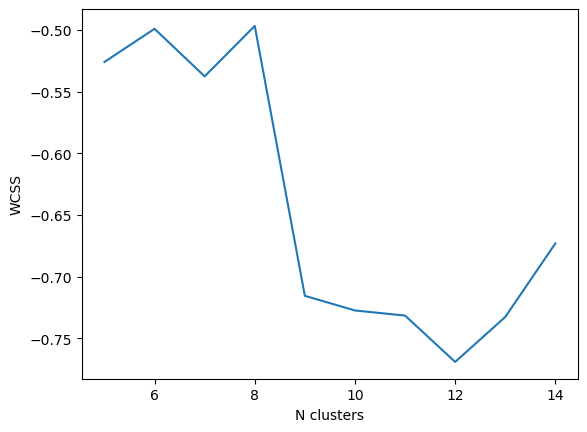

In [73]:
elbow_method(df_pca_dummy, 5, 15)

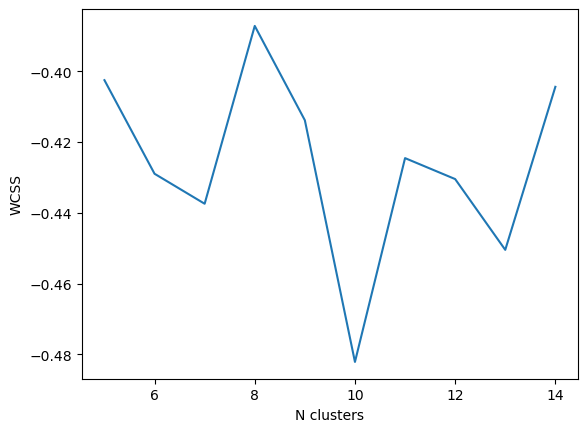

In [74]:
elbow_method(df_pca_indexed, 5, 15)

* Use df_pca_dummy with k = 9

In [97]:
kmeans_model = KMeans(k=9, featuresCol='pca_features', predictionCol='prediction')
predictions = kmeans_model.fit(df_pca_dummy).transform(df_pca_dummy)

In [98]:
predictions.show(5)

+--------------------+--------+-----------------+--------+-------+----+---------+-----+---------------+------------------+------------+-------+-------------+----------+--------+------------+--------+------+----+-------+--------+------------+-----------------+---------+------+-------+----------+------+-----------+--------------+------+-----------+-------+----------+--------+-----------+------+--------+------------+-------+---------+---------------+------------+-----------------+-----------------+-------+--------+------------------------------+-----------------------+------+------+-------------+------+------+---------+---------+-----+------------+--------------+-------+-------+--------+-------+-----+---------+-----------+------+--------------+---------------+--------------+----------------+--------------+---+-----+-----------+------+----+-------------------+---------+----------------+---------+----------+--------+---------------+--------------+------+-----+------+------------+---------+-

# Fiding similar

In [119]:
def find_similar(df, item_id):
    cluster = df.filter(predictions.id == item_id).select('prediction').collect()[0][0]
    print(cluster)
    return df.filter(predictions.prediction == cluster)

In [104]:
similar = find_similar(predictions, predictions.take(1)[0]['id'])

In [105]:
similar.show(5)

+--------------------+--------+-----------------+--------+-------+----+---------+-----+---------------+------------------+------------+-------+-------------+----------+--------+------------+--------+------+----+-------+--------+------------+-----------------+---------+------+-------+----------+------+-----------+--------------+------+-----------+-------+----------+--------+-----------+------+--------+------------+-------+---------+---------------+------------+-----------------+-----------------+-------+--------+------------------------------+-----------------------+------+------+-------------+------+------+---------+---------+-----+------------+--------------+-------+-------+--------+-------+-----+---------+-----------+------+--------------+---------------+--------------+----------------+--------------+---+-----+-----------+------+----+-------------------+---------+----------------+---------+----------+--------+---------------+--------------+------+-----+------+------------+---------+-

In [116]:
similar.select('bairro').show(15)

+------------+
|      bairro|
+------------+
|       Méier|
|  Copacabana|
|       Lagoa|
| Laranjeiras|
|    Botafogo|
|      Tijuca|
|Tomás Coelho|
|       Lagoa|
|     Humaitá|
|      Leblon|
|      Tijuca|
|     Ipanema|
|  Copacabana|
|      Tijuca|
|  Copacabana|
+------------+
only showing top 15 rows



In [123]:
find_similar(predictions, predictions.take(3)[-1]['id']).select('bairro').show(15)

0
+--------------------+
|              bairro|
+--------------------+
|Recreio dos Bande...|
|Recreio dos Bande...|
|Recreio dos Bande...|
|Recreio dos Bande...|
|               Bangu|
|Recreio dos Bande...|
|Recreio dos Bande...|
|      Jardim Sulacap|
|     Barra da Tijuca|
|Recreio dos Bande...|
|      Vila Valqueire|
|         Jacarepaguá|
|Recreio dos Bande...|
|     Barra da Tijuca|
|         Jacarepaguá|
+--------------------+
only showing top 15 rows

